In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [2]:
filepath = Path("../../data/file_transfer/save_times.json")
with filepath.open() as f:
    perf: dict = dict(json.load(f))

# All data

- 4 sample areas were acquired (same sample, different regions), each with 4 data dimensions
- 1 blank set was acquired

Scan IDs:
- 14-17: sample area 1 (128, 256, 512, 1024)
- 18-21: sample area 2 (128, 256, 512, 1024)
- 22-25: sample area 3 (128, 256, 512, 1024)
- 26-29: sample area 4 (128, 256, 512, 1024)
- 93-96: blank (128, 256, 512, 1024)

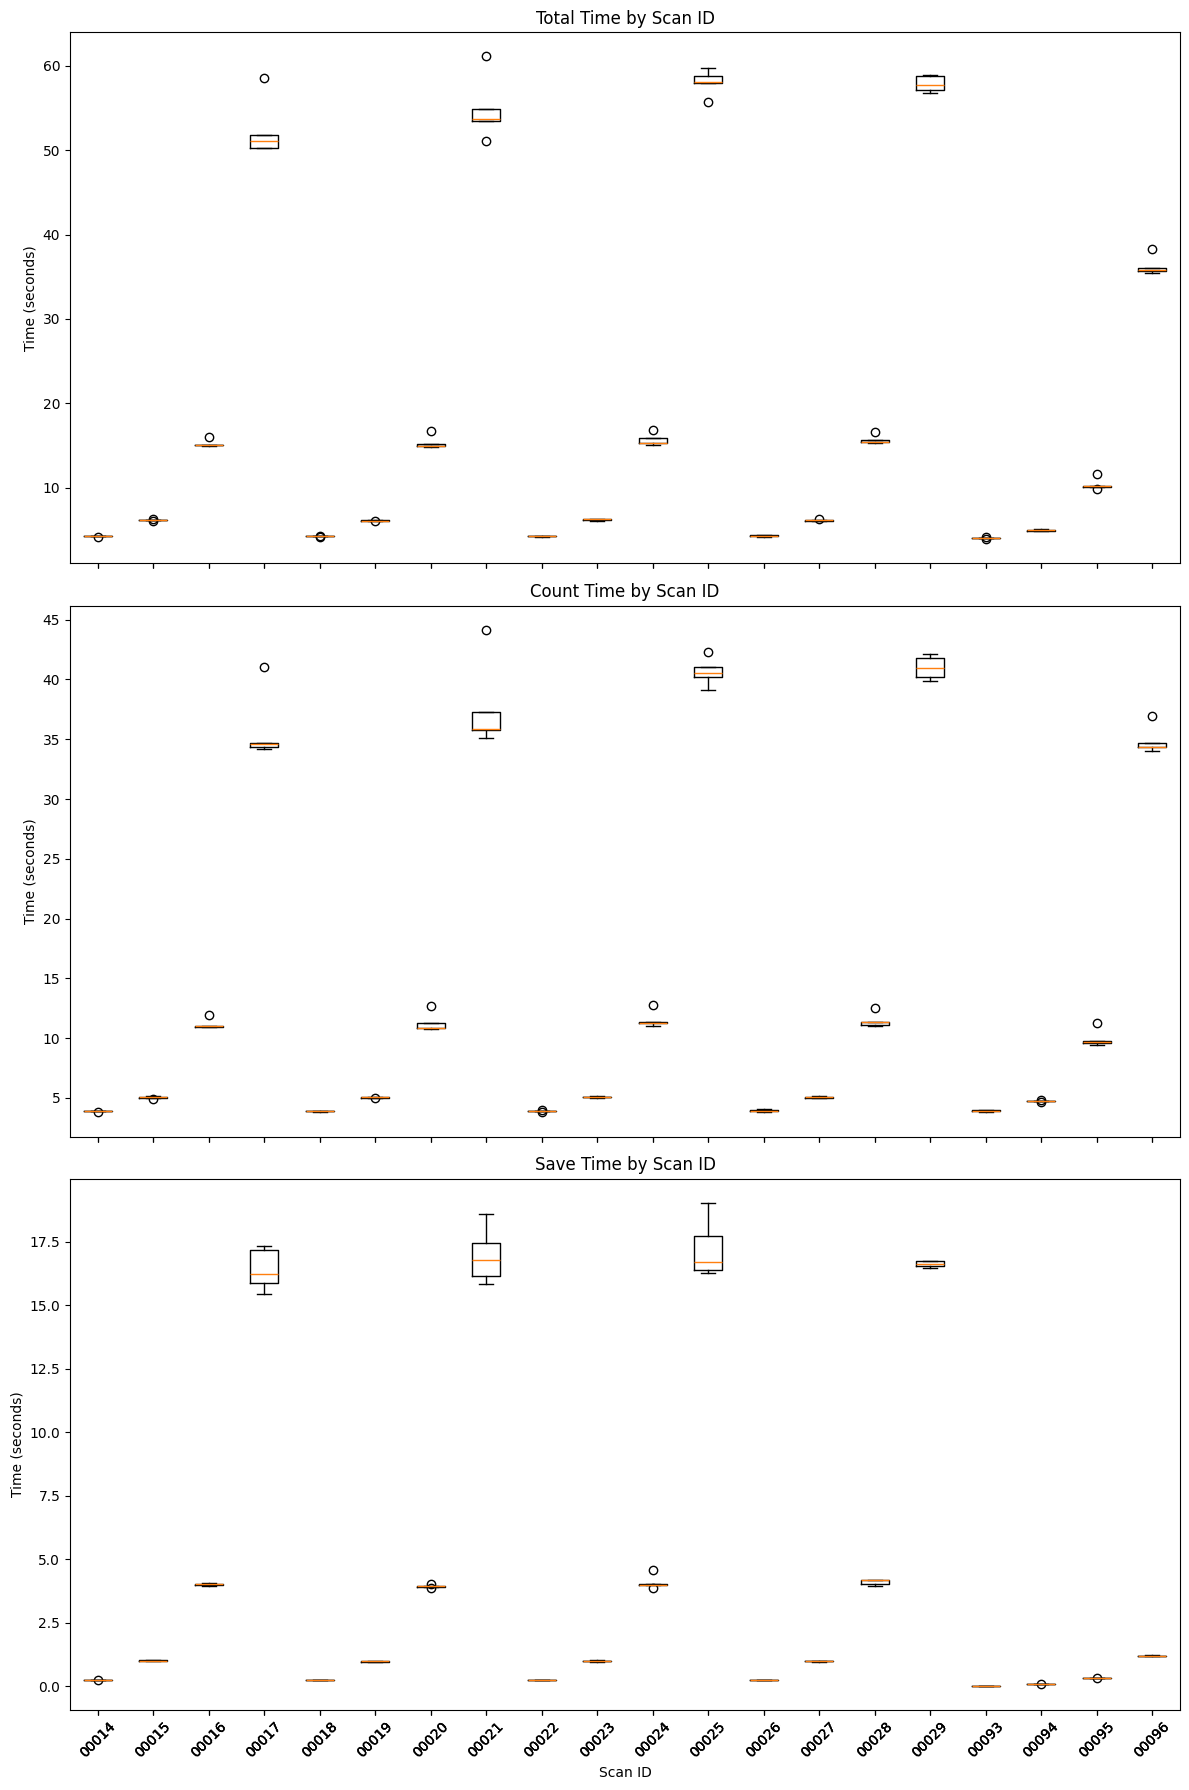

In [3]:
rows = []
for scan_id, entries in perf.items():
    for entry in entries:
        entry['scan_id'] = scan_id
        rows.append(entry)

df = pd.DataFrame(rows)

# Create box plots
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Total time
axs[0].boxplot([df[df['scan_id'] == sid]['total_time'] for sid in df['scan_id'].unique()], labels=df['scan_id'].unique())
axs[0].set_title('Total Time by Scan ID')
axs[0].set_ylabel('Time (seconds)')

# Count time
axs[1].boxplot([df[df['scan_id'] == sid]['count_time'] for sid in df['scan_id'].unique()], labels=df['scan_id'].unique())
axs[1].set_title('Count Time by Scan ID')
axs[1].set_ylabel('Time (seconds)')

# Save time
axs[2].boxplot([df[df['scan_id'] == sid]['save_time'] for sid in df['scan_id'].unique()], labels=df['scan_id'].unique())
axs[2].set_title('Save Time by Scan ID')
axs[2].set_ylabel('Time (seconds)')

plt.xlabel('Scan ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Statistics

### Get file sizes

In [4]:
from pathlib import Path
import datetime as dt

# Define the directory and time range for filtering

def file_sizes_from_dir(directory, time_upper, time_lower, ranges):
    file_sizes = {128: [], 256: [], 512: [], 1024: []}
        # Loop over each file in the directory
    for file in directory.glob('**/*.h5'):
        # Extract the time from the filename
        time_str = file.name.split('_')[2]  # Assuming time is the third element
        file_time = dt.datetime.strptime(time_str, "%H%M").time()
        
        # Check if the time of the file is within the specified range
        if time_lower <= file_time <= time_upper:
            # Get file size in megabytes
            file_size_mb = file.stat().st_size / 1e6

            # Categorize file size
            if ranges[0][0] < file_size_mb <= ranges[0][1]:
                file_sizes[128].append(file_size_mb)
            elif ranges[1][0]< file_size_mb <= ranges[1][1] :
                file_sizes[256].append(file_size_mb)
            elif ranges[2][0]  < file_size_mb <= ranges[2][1]:
                file_sizes[512].append(file_size_mb)
            elif ranges[3][0]< file_size_mb <= ranges[3][1]:
                file_sizes[1024].append(file_size_mb)

    # Calculate the average sizes in MB for each category
    avg_sizes = {k: sum(v) / len(v) for k, v in file_sizes.items() if v}
    return avg_sizes



directory = Path("./test-real-data")
time_lower = dt.time(7, 28, 0)
time_upper = dt.time(8, 24, 0)
ranges = [(0,100),(100, 400),(400, 1600),(1600, 6000)]
file_sizes_real = file_sizes_from_dir(directory, time_upper, time_lower, ranges)

directory = Path("./test-blank-data")
time_lower = dt.time(8, 23, 0)
time_upper = dt.time(8, 31, 0)
ranges = [(1,1.2),(3.5, 4.0),(15, 17),(34, 36)]
file_sizes_blank = file_sizes_from_dir(directory, time_upper, time_lower, ranges)

# Since these are from my perlmutter scratch directory, we just set the outputs manually here:
file_sizes_blank = {128: 1.054208, 256: 3.945984, 512: 15.734272, 1024: 35.214848}
file_sizes_real = {128: 87.74122514285715, 256: 351.02443800000003, 512: 1388.924552, 1024: 5553.59808}

print(f"Blank sizes: {file_sizes_blank}")
print(f"Real sizes: {file_sizes_real}")


Blank sizes: {128: 1.054208, 256: 3.945984, 512: 15.734272, 1024: 35.214848}
Real sizes: {128: 87.74122514285715, 256: 351.02443800000003, 512: 1388.924552, 1024: 5553.59808}


### Make table

In [6]:
size_map: dict[int, list[str]] = {128: ["00014","00018", "00022","00026", "00093",],
                                  256:["00015","00019","00023","00027","00094"],
                                  512: ["00016","00020","00024","00028","00095"], 
                                  1024: ["00017","00021","00025","00029","00096"]}

blank: list[str] = ["00093","00094","00095","00096"]
real: list[str] = [f"{x:05}" for x in range(14, 30, 1)]

# Adding size and type (Real/Blank) to each entry in DataFrame
df['Size'] = None
df['Type'] = None
for size, scans in size_map.items():
    for scan in scans:
        df.loc[df['scan_id'] == scan, 'Size'] = size
        df.loc[df['scan_id'] == scan, 'Type'] = 'Blank' if scan in blank else 'Real'

# Calculate statistics for each category and size
columns = pd.MultiIndex.from_product(
    [size_map.keys(), ['Real', 'Blank'], ['mean', 'std']],
    names=['Size', 'Type', 'Stat']
)
stats = pd.DataFrame(index=['total_time', 'count_time', 'save_time'], columns=columns)

# Populate the DataFrame
for size, scans in size_map.items():
    for type_key in ['Real', 'Blank']:
        subset = df[(df['Size'] == size) & (df['Type'] == type_key)]
        for measure in ['total_time', 'count_time', 'save_time']:
            stats.loc[measure, (size, type_key, 'mean')] = subset[measure].mean()
            stats.loc[measure, (size, type_key, 'std')] = subset[measure].std()

stats = stats.transpose()
stats.to_csv(Path("../../data/file_transfer/save_time_stats.csv"))
print(stats)

                total_time count_time  save_time
Size Type  Stat                                 
128  Real  mean   4.238761   3.914407   0.254895
           std    0.060251   0.058043   0.005527
     Blank mean   4.002132   3.907211   0.026997
           std    0.085512   0.083481   0.001045
256  Real  mean   6.135601   5.060185   0.991351
           std    0.089436   0.058351    0.02039
     Blank mean   4.946754   4.766327   0.084854
           std    0.088806   0.054962   0.003603
512  Real  mean  15.452975  11.358298   4.033507
           std    0.620902   0.624047   0.158282
     Blank mean  10.374574   9.936051   0.333619
           std    0.709247   0.735505   0.004324
1024 Real  mean  55.776355  38.750354  16.801823
           std    3.464209   3.200772   0.885109
     Blank mean   36.26251  34.874016   1.203411
           std    1.182082   1.180346   0.006746


### Look at hdf5 save rate

In [7]:
save_time_stats = {
    (size, type_key): {
        'mean': stats.loc[(size, type_key, 'mean'), 'save_time'],
        'std': stats.loc[(size, type_key, 'std'), 'save_time']
    }
    for size in [128, 256, 512, 1024]
    for type_key in ['Real']
    if (size, type_key, 'mean') in stats.index 
}

# Calculate data saving rate in MB/s
saving_rates = {}
for size in [128, 256, 512, 1024]:
    for type_key in ['Real']:
        if size in file_sizes_real and (size, type_key) in save_time_stats:
            avg_file_size = file_sizes_real[size]  # Average file size in MB
            avg_save_time = save_time_stats[(size, type_key)]['mean']  # Average save time in seconds
            saving_rate = avg_file_size / avg_save_time if avg_save_time != 0 else 0
            saving_rates[(size, type_key)] = saving_rate
            

# Print the calculated data saving rates
for key, rate in saving_rates.items():
    print(f"Data saving rate for data of size {key[0]}MB: {rate:.2f} MB/s")

rates = [rate for rate in saving_rates.values()]
avg = sum(rates) / len(rates)
print(f"Average: {avg:.2f} MB/s")

Data saving rate for data of size 128MB: 344.22 MB/s
Data saving rate for data of size 256MB: 354.09 MB/s
Data saving rate for data of size 512MB: 344.35 MB/s
Data saving rate for data of size 1024MB: 330.54 MB/s
Average: 343.30 MB/s
